# 0 처음 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import os
os.chdir('/content/drive/MyDrive/015GithubRepos/da_for_sbr')

import pickle
import os
import matplotlib.pyplot as plt
from collections import Counter
import math
import numpy as np
import time

from simmetric import *
from utils import *

experiment = 1
# 불러올 데이터 선택
y_or_d = 'yoochoose'  # yoochoose or diginetica
frac = 1/64

# 경로설정 ###############################################
# colab
dataPATH = '/content/drive/MyDrive/015GithubRepos/da_for_sbr/exps'
expPATH = '/content/drive/MyDrive/015GithubRepos/da_for_sbr/exps'

# spyder
# dataPATH = 'G:/내 드라이브/015GithubRepos/da_for_sbr/exps'
# expPATH = 'G:/내 드라이브/015GithubRepos/da_for_sbr/exps'
# 경로설정 ###############################################


# tra_seqs_frac : 아이템 시퀀스 불러오기
tra_seqs_frac = load_tra_seqs_frac(experiment, y_or_d, frac)
nof_sessions = len(tra_seqs_frac)

# allaprcnt : 모든 출현 카운트(int)
allsess = []
for s in tra_seqs_frac:
  allsess += s
allaprcnt = len(allsess)
print(f'모든 세션의 아이템 출현 수 : {allaprcnt}')

# allitemcntr : 아이템별 출현횟수 카운트
allitemcntr = Counter(allsess)

# most similar dictionary 불러오기
msd = load_msd('jac', experiment, y_or_d, frac)

# nof_items : 아이템 수
nof_items = len(allitemcntr)

print(f'총 아이템 수 : {nof_items}')

# 1 아이템 특성

## 스코어 딕셔너리 생성

### 스코어 계산 첫 번째 방법

In [ ]:
make_save_msd('jac', 1, y_or_d, 1/64)

로드 유사도행렬 : exps/experiment1/yoochoose/y064_csr_jac_mat.pkl
filename : exps/experiment1/yoochoose/y064_jac_msd.pkl


In [ ]:
#%% falog2만들기, hs딕셔너리(msd, most hightest similarity dictionary) 불러오기


falog2 = {k:math.log2(v+1) for k, v in allitemcntr.items()}

from simmetric import *
msd = load_msd('jac', experiment, y_or_d, frac)


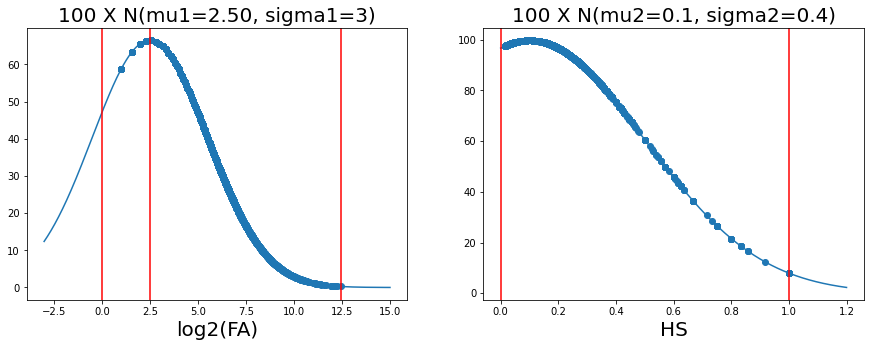

In [ ]:
#%% hyperparameter setting

alpha = 500
mu1 = 2.5
sigma1 = 3

beta = 500
mu2 = 0.1
sigma2 = 0.4




#%% 출현빈도 그리기 ##############################################


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)


min(falog2.values())
min(allitemcntr.values())


M = max(falog2.values())

# x, y 생성
x = [falog2[i] for i in range(1, nof_items+1)]
y = [alpha * gaussian(mu1, sigma1, _) for _ in x]
plt.scatter(x, y)

# 가우시안 선
x = np.linspace(-3, 15, 1000)
y = gaussian(mu1, sigma1, x) * alpha
plt.plot(x, y)

# 수선
plt.axvline(x=0, color='r')
plt.axvline(x=mu1, color='r')
plt.axvline(x=M, color='r')


plt.xlabel('log2(FA)', fontsize=20)
plt.title(f'100 X N(mu1={mu1:.2f}, sigma1={sigma1})', fontsize=20)
#####################################################################


#%%

plt.subplot(1, 2, 2)

x = [msd[i][1] for i in range(1, nof_items+1)]
y = [100*gaussian(mu2, sigma2, _) for _ in x]

plt.scatter(x, y)

# 가우시안 선
x = np.linspace(0, 1.2, 1000)
y = gaussian(mu2, sigma2, x) * 100
plt.plot(x, y)

# 수선
plt.axvline(x=0, color='r')
plt.axvline(x=1, color='r')


plt.xlabel('HS', fontsize=20)
plt.title(f'100 X N(mu2={mu2}, sigma2={sigma2})', fontsize=20)
#####################################################################

theta = [alpha, mu1, sigma1, beta, mu2, sigma2]

def cal_score(logfa: float , hsvalue: float, theta) -> float:

  alpha, mu1, sigma1, beta, mu2, sigma2 = theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]

  alphaterm = alpha * gaussian(mu1, sigma1, logfa)
  betaterm = beta * gaussian(mu2, sigma2, hsvalue)

  score = alphaterm + betaterm

  return score

score = {i : cal_score(falog2[i], msd[i][1], theta) for i in range(1, nof_items+1)}

---

### 스코어 계산 두 번째 방법
(출현빈도 낮고 최고유사도 값 높은 아이템에만 집중한 증강 프로세스 정립?)

$s = \frac{100HS}{\sqrt{FA}}$

In [ ]:
# msd 로드
msd = load_msd('jac', experiment, y_or_d, frac)

# 출현빈도 역수
fa_sqrt = {k:math.sqrt(v) for k, v in allitemcntr.items()}
score = {i: 100 * msd[i][1]/fa_sqrt[i] for i in range(1, nof_items+1)}  # 아이템별 score 딕셔너리 계산

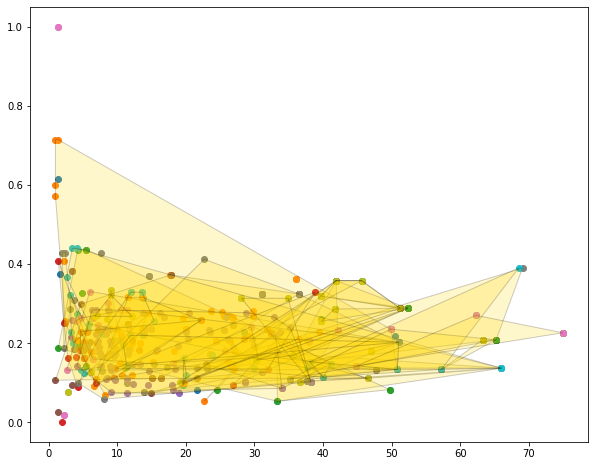

In [ ]:
plt.figure(figsize=(10, 8))

items = set()
for sid in range(100, 200):

  items |= set(tra_seqs_frac[sid])
  fa = [fa_sqrt[i] for i in tra_seqs_frac[sid]]
  hs = [msd[i][1] for i in tra_seqs_frac[sid]]
  plt.scatter(fa, hs)
  if len(set(fa)) >= 3:
    encircle(fa, hs, ec="k", fc="gold", alpha=0.2)

# for i in items:
#   ms_i = msd[i][0]
#   plt.plot([allitemcntr[i], allitemcntr[ms_i]], [msd[i][1], msd[ms_i][1]], 'r')

In [ ]:
str_tra_seqs = []
for s in tra_seqs_frac:
    str_tra_seqs.append(list(map(str, s)))

model = Word2Vec(sentences=str_tra_seqs, size=2, window=5, min_count=1, workers=4, sg=0)

In [ ]:
model.wv.get_vector('3')

array([-1.6924365,  0.7515889], dtype=float32)

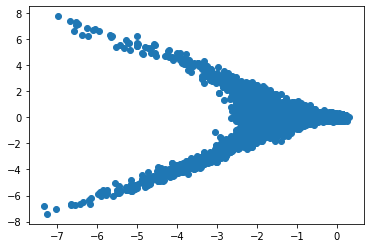

In [ ]:
w2v_x = [model.wv.get_vector(str(i))[0] for i in range(1, nof_items+1)]
w2v_y = [model.wv.get_vector(str(i))[1] for i in range(1, nof_items+1)]
plt.scatter(w2v_x, w2v_y)

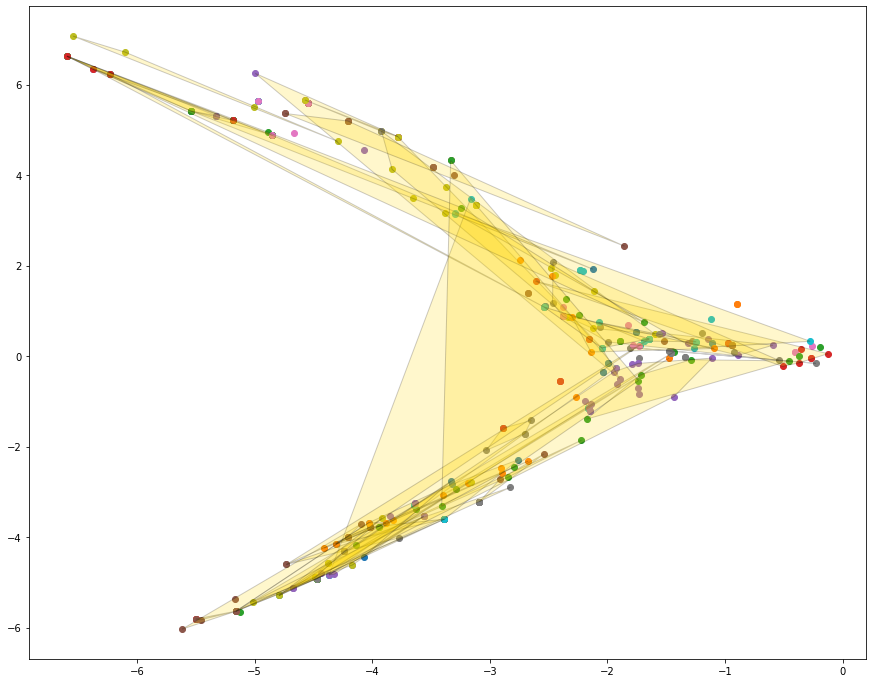

In [ ]:
plt.figure(figsize=(15, 12))

items = set()
for sid in range(200, 300):

  items |= set(tra_seqs_frac[sid])
  w2vx = [model.wv.get_vector(str(i))[0] for i in tra_seqs_frac[sid]]
  w2vy = [model.wv.get_vector(str(i))[1] for i in tra_seqs_frac[sid]]
  plt.scatter(w2vx, w2vy)
  if len(set(w2vx)) >= 3:
    encircle(w2vx, w2vy, ec="k", fc="gold", alpha=0.2)

# for i in items:
#   ms_i = msd[i][0]
#   plt.plot([allitemcntr[i], allitemcntr[ms_i]], [msd[i][1], msd[ms_i][1]], 'r')

In [ ]:
import pandas as pd

In [ ]:
points = pd.DataFrame({'x' : x, 'y' : y})
points

,x,y
0,21,0.172043
1,681,0.210832
2,882,0.210832
3,4355,0.136986
4,882,0.210832


In [ ]:
hull = ConvexHull(points)

In [ ]:
hull.vertices

array([0, 3, 2, 1], dtype=int32)

In [ ]:
p

NameError: ignored

In [ ]:
np.c_[x1,y1]

array([[8.24869073, 2.80021747],
       [3.77648717, 4.65514358],
       [3.9436565 , 3.24428316],
       [2.85406276, 5.08442749],
       [6.73081526, 6.16563043],
       [0.39692261, 2.79876165],
       [8.48962353, 7.28944742],
       [3.4775862 , 6.80318144],
       [5.63807819, 6.00498868],
       [4.50125925, 6.8017119 ],
       [7.92421587, 3.63254428],
       [0.87971858, 4.75421955],
       [4.35516559, 3.12846113],
       [4.23189129, 4.46422384],
       [7.26753888, 6.06071093]])

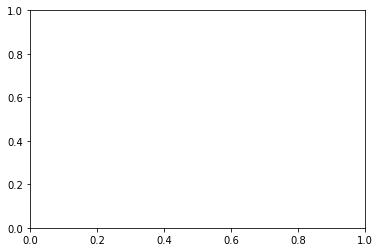

In [ ]:

import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
from scipy.spatial import ConvexHull
# plt.scatter(x, y)
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)
encircle(fa, hs, ec="k", fc="gold", alpha=0.2)
plt.show()

In [ ]:
x1

array([8.24869073, 3.77648717, 3.9436565 , 2.85406276, 6.73081526,
       0.39692261, 8.48962353, 3.4775862 , 5.63807819, 4.50125925,
       7.92421587, 0.87971858, 4.35516559, 4.23189129, 7.26753888])

In [ ]:
y1

array([2.80021747, 4.65514358, 3.24428316, 5.08442749, 6.16563043,
       2.79876165, 7.28944742, 6.80318144, 6.00498868, 6.8017119 ,
       3.63254428, 4.75421955, 3.12846113, 4.46422384, 6.06071093])

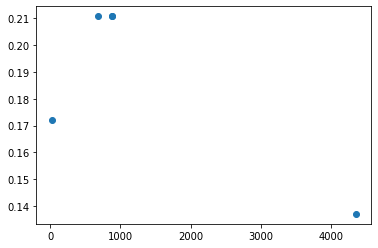

In [ ]:
from scipy.spatial import ConvexHull

plt.scatter(x, y)

In [ ]:
for sid in [51, 8432, 8468, 50000, 68880, 98070, 120000]:
  testss = tra_seqs_frac[sid].copy()
  print(f'아이템 \t FA \t (FA) \t HS \t \t 100HS \t\t Score')
  for idx in range(len(testss)):
      item = testss[idx]
      print(f'{item:5} \t {allitemcntr[item]:4} \t {fa_sqrt[item]:^10.2f} \t {msd[item][1]:>6.4f} \t {msd[item][1]*100:>6.2f} \t {score[item]:.4f}')

  m = np.mean([score[i] for i in testss])
  print(f'mean = {m:.4f}')
  
  print()

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Score
   55 	 4355 	  4355.00   	 0.0499 	   4.99 	 0.0011
    5 	 3999 	  3999.00   	 0.1312 	  13.12 	 0.0033
mean = 0.0022

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Score
   14 	 1447 	  1447.00   	 0.0574 	   5.74 	 0.0040
   13 	 2622 	  2622.00   	 0.1033 	  10.33 	 0.0039
  134 	 1578 	  1578.00   	 0.0919 	   9.19 	 0.0058
   12 	 2740 	  2740.00   	 0.1066 	  10.66 	 0.0039
mean = 0.0044

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Score
  518 	 1310 	  1310.00   	 0.1019 	  10.19 	 0.0078
  164 	 1571 	  1571.00   	 0.0851 	   8.51 	 0.0054
  133 	 1623 	  1623.00   	 0.0873 	   8.73 	 0.0054
mean = 0.0062

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Score
  176 	 2471 	  2471.00   	 0.0384 	   3.84 	 0.0016
  176 	 2471 	  2471.00   	 0.0384 	   3.84 	 0.0016
mean = 0.0016

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Score
  118 	  485 	   485.00   	 0.0343 	   3.43 	 0.0071
  776 	  905 	   905.00   	 0.0840 	   8.40 	 0.0093
mean = 0.0082

아이템 	 FA 	 (FA) 	 HS 	 	 100HS 		 Sc

### 네 번째 방법 세션들의 FA, HS 평균 계산

In [ ]:
fas = []
hss = []
scores=[]
nof_i = []


rand_idxs = np.random.randint(1, nof_sessions+1, size=10000)
for i in range(1, nof_sessions):
  s = tra_seqs_frac[i]
  fas.append(np.mean([allitemcntr[_] for _ in s]))
  hss.append(np.mean([msd[_][1] for _ in s]))
  scores.append(np.mean([score[_] for _ in s]))
  nof_i.append(len(s))

nof_i = np.array(nof_i)*100

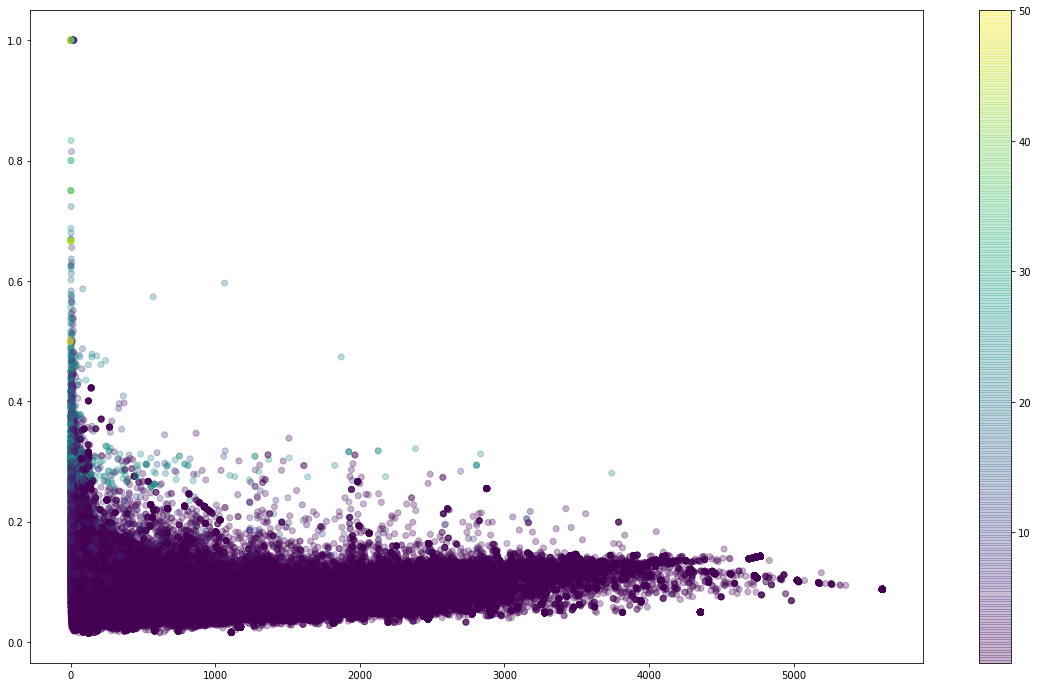

In [ ]:
plt.figure(figsize=(20, 12))

plt.scatter(fas, hss, c=scores, alpha=0.3)
plt.colorbar()

In [ ]:
score = {i: 100 * msd[i][1]/allitemcntr[i] for i in range(1, nof_items+1)}  # 아이템별 score 딕셔너리 계산

coo_mat = load_sim_mat('coo', 1, 'yoochoose', 1/64)

로드 유사도행렬 : exps/experiment1/yoochoose/y064_csr_coo_mat.pkl


In [ ]:
def get_sim_betclus(cl1, cl2):

  sims = []
  for a in cl1:
    for b in cl2:
      sims.append(coo_mat[a][b])

  return np.mean(sims)

In [ ]:
nof_items // 10

1759

In [ ]:
clusters = {}
for i in range(1, nof_items+1):
  temp = set()
  temp.add(i)
  clusters[i] = temp


starttime = time.time()
keepgo = 1
while keepgo:
  for cl_id in range(1, nof_items+1):  # 클러스터링 전체 한바퀴
    if cl_id in clusters:
      maxsim = 0
      maxid = cl_id
      for oth_cl_id in range(1, nof_items+1):  # 자기 빼고 다른클러스터 돌면서
        if cl_id != oth_cl_id and oth_cl_id in clusters:  # 
          sim = get_sim_betclus(clusters[cl_id], clusters[oth_cl_id])
          if maxsim < sim:
            maxsim = sim
            maxid = oth_cl_id

      clusters[cl_id] = clusters[cl_id].union(clusters[maxid])
      del clusters[maxid]

      # print ##################################
      if len(clusters) % 500 == 0:
        sec = time.time() - starttime
        print(f'nof_clusters : {len(clusters)}, \t{int(sec//60)}min {int(sec%60)}sec')
        for printk in clusters.keys()[:3]:
          print(f'{clusters[printk]}')
        print()
      # print ##################################

      if len(clusters) == nof_items // 10:
        keepgo = 0
        print(f'nof_clusters : {len(clusters)}, \t{int(sec//60)}min {int(sec%60)}sec')
        break


In [ ]:
sid = 8788
s = tra_seqs_frac[sid].copy()

In [ ]:
s

[1592, 4990]

In [ ]:
ar = 0.3  # augmentation rate
nof_aug = int(nof_sessions * ar)  # number of augmentation
print(f'number of sessions : {nof_sessions} \naugmentation rate(ar) : {ar}\nhow many sessions to augment : {nof_aug}')

cr = 0.5  # choice rate
print(f'choice rate : {ar}')

number of sessions : 124472 
augmentation rate(ar) : 0.3
how many sessions to augment : 37341
choice rate : 0.3


In [ ]:
aug_sess = []  # 증강 완료된 세션을 모음


cnt = 0
for sid, session in enumerate(tra_seqs_frac):

  s = tra_seqs_frac[sid].copy()  # 안변하고 참고하는거
  sess = tra_seqs_frac[sid].copy()  # 실제로 변하는거
  slen = len(sess)

  scorelist = np.array([score[item] for item in sess])
  p = np.array(scorelist) / np.sum(scorelist)
  augidxs = np.random.choice(range(len(sess)), math.floor(len(sess) * cr), replace=False, p=p)
  nof_sub = np.random.choice(slen + 1, 1)[0]  # 대체할 개수
  sub_it_idxs = augidxs[:nof_sub]
  isrt_it_idxs = augidxs[nof_sub:]
  # sforsub에 대체
  for sitidx in sub_it_idxs:
    # 가장 유사한 아이템 찾기 -> 자기 자신과만 유사한 아이템만 아니면 대체
    mostsimitem_s = msd[sess[sitidx]][0]
    if sess[sitidx] != mostsimitem_s:
      sess[sitidx] = mostsimitem_s  # 대체
  # 삽입할 아이템 구하기
  isrt_items = []  # 삽입할 아이템을 모음
  isrt_it_idxs_over = []  # 삽입할 인덱스를 모음
  for iitidx in isrt_it_idxs:
    # 가장 유사한 아이템 찾기 -> 자기자신과만 유사한 아이템 아니면 삽입
    mostsimitem_i = msd[sess[iitidx]][0]
    if sess[iitidx] != mostsimitem_i:
      isrt_items.append(mostsimitem_i)  # 삽입할 아이템
      isrt_it_idxs_over.append(iitidx)  # 삽입할 인덱스
  sess = np.insert(np.asarray(sess), isrt_it_idxs_over, isrt_items)  # 삽입
  sess = list(sess)
  
  print(f'sid : {sid} \t s : {s}')
  if sess not in tra_seqs_frac and sess not in aug_sess:
    aug_sess.append(sess)
    cnt += 1
    print(f'************성공***************')
    print(sess)
  if sid % 2000 == 0:
    print(f'sid : {sid}---------------------------------------')
  
  if nof_aug == cnt:
    break

  

In [ ]:
print(f'{len(aug_sess)}')

24408


In [ ]:
sid

117056

## 세션을 스코어평균 높은순으로 정렬

In [ ]:
sess_s_mean = dict()
for sid, s in enumerate(tra_seqs_frac):
  scorelist = [score[item] for idx, item in enumerate(s)]
  sess_s_mean[sid] = (np.mean(scorelist), len(s))  # sess_s_mean[session id] = (session's score mean, session length)

aug_target = sorted(sess_s_mean.items(), key=lambda x: (x[1][0], -x[1][1]), reverse=True)
aug_target[:10]  # (세션id, (스코어평균, 아이템수))

[(3454, (100.0, 2)),
 (6759, (100.0, 2)),
 (12169, (100.0, 2)),
 (12325, (100.0, 2)),
 (12965, (100.0, 2)),
 (17373, (100.0, 2)),
 (22854, (100.0, 2)),
 (22993, (100.0, 2)),
 (26261, (100.0, 2)),
 (27285, (100.0, 2))]

In [ ]:
aug_target_idx = [_[0] for _ in aug_target]
aug_target_idx[:10]  # 스코어평균 상위 10개 세션의 id

[3454, 6759, 12169, 12325, 12965, 17373, 22854, 22993, 26261, 27285]

# 3 증강
(증강 안되는 세션은 건너뛰기)

## 3-1 파라미터 설정

In [ ]:
ar = 0.5  # augmentation rate
nof_aug = int(nof_sessions * ar)  # number of augmentation
print(f'number of sessions : {nof_sessions} \naugmentation rate(ar) : {ar}\nhow many sessions to augment : {nof_aug}')

cr = 0.5  # choice rate
print(f'choice rate : {cr}')

number of sessions : 124472 
augmentation rate(ar) : 0.5
how many sessions to augment : 62236
choice rate : 0.5


## 3-2 스코어에 의한 증강

In [ ]:
cnt = 0  # 증강 성공할때마다 하나씩 카운트
aug_sess = []  # 증강 완료된 세션을 모음
verbose = 30
for rank, sid in enumerate(aug_target_idx):

  s = tra_seqs_frac[sid].copy()  # 안변하고 참고하는거
  sess = tra_seqs_frac[sid].copy()  # 실제로 변하는거
  slen = len(sess)

  scorelist = np.array([score[item] for item in sess])

  p = np.array(scorelist) / np.sum(scorelist)

  augidxs = np.random.choice(range(len(sess)), math.floor(len(sess) * cr), replace=False, p=p)

  nof_sub = np.random.choice(slen + 1, 1)[0]  # 대체할 개수
  sub_it_idxs = augidxs[:nof_sub]
  isrt_it_idxs = augidxs[nof_sub:]

  # sforsub에 대체
  for sitidx in sub_it_idxs:
    # 가장 유사한 아이템 찾기 -> 자기 자신과만 유사한 아이템만 아니면 대체
    mostsimitem_s = msd[sess[sitidx]][0]
    if sess[sitidx] != mostsimitem_s:
      sess[sitidx] = mostsimitem_s  # 대체
  
  # 삽입할 아이템 구하기
  isrt_items = []  # 삽입할 아이템을 모음
  isrt_it_idxs_over = []  # 삽입할 인덱스를 모음
  for iitidx in isrt_it_idxs:
    # 가장 유사한 아이템 찾기 -> 자기자신과만 유사한 아이템 아니면 삽입
    mostsimitem_i = msd[sess[iitidx]][0]
    if sess[iitidx] != mostsimitem_i:
      isrt_items.append(mostsimitem_i)  # 삽입할 아이템
      isrt_it_idxs_over.append(iitidx)  # 삽입할 인덱스

  sess = np.insert(np.asarray(sess), isrt_it_idxs_over, isrt_items)  # 삽입
  sess = list(sess)

  if sess not in tra_seqs_frac and sess not in aug_sess:  # 원본 세션에도 없고, 증강된 세션중에도 없어야함
    cnt += 1
    aug_sess.append(sess)
  


  if rank <= 30:
    if sess not in tra_seqs_frac and sess not in aug_sess:  # 원본 세션에도 없고, 증강된 세션중에도 없어야함
      print('*******************성공')
    if sess in tra_seqs_frac:
      print(f'원본에 있음')
    if sess in aug_sess:
      print(f'증강에 있음')
    print(f'순위 : {rank}')
    print(f'원래 세션   : {s}')
    print(f'증강된 세션 : {sess}')
    a, b, c, d, e, f = '아이템', 'FA', 'sqrt(FA)', 'HS', '100HS', 'score'
    print(f'{a:>10}{b:^10}{c:^10}{d:^10}{e:^10}{f:^10}')
    for idx in range(len(s)):
      item = s[idx]
      print(f'{item:>10}{allitemcntr[item]:^10}{allitemcntr[item]:^10.2f}{msd[item][1]:^10.4f}{msd[item][1]*100:^10.2f}{score[item]:^10.2f}')
    
    print(f'p : [', end='')
    for _ in p:
      print(f'{_:.4f}', end=' ')
    print(f']')
    print(f'score mean: {np.mean(scorelist):.2f}')
    print(f'cnt : {cnt}')
    print()

  if cnt == nof_aug:
    break



순위 : 0
원래 세션   : [2875, 2876]
증강된 세션 : [2876, 2875, 2876]
       아이템    FA     sqrt(FA)     HS      100HS     score   
      2875    1        1.00     1.0000    100.00    100.00  
      2876    1        1.00     1.0000    100.00    100.00  
p : [0.5000 0.5000 ]
score mean: 100.00
cnt : 1

순위 : 1
원래 세션   : [4232, 4233]
증강된 세션 : [4232, 4232, 4233]
       아이템    FA     sqrt(FA)     HS      100HS     score   
      4232    1        1.00     1.0000    100.00    100.00  
      4233    1        1.00     1.0000    100.00    100.00  
p : [0.5000 0.5000 ]
score mean: 100.00
cnt : 2

순위 : 2
원래 세션   : [6241, 6242]
증강된 세션 : [6241, 6241, 6242]
       아이템    FA     sqrt(FA)     HS      100HS     score   
      6241    1        1.00     1.0000    100.00    100.00  
      6242    1        1.00     1.0000    100.00    100.00  
p : [0.5000 0.5000 ]
score mean: 100.00
cnt : 3

순위 : 3
원래 세션   : [6295, 6296]
증강된 세션 : [6296, 6296]
       아이템    FA     sqrt(FA)     HS      100HS     score   
      6295    1  

## 3-3 무작위 증강

In [ ]:
rand_aug_target_idx = np.random.choice(len(tra_seqs_frac), nof_aug, replace=False)

In [ ]:
cnt = 0  # 증강 성공할때마다 하나씩 카운트
rand_aug_sess = []  # 증강 완료된 세션을 모음
verbose = 30

for sid in rand_aug_target_idx:

  s = tra_seqs_frac[sid].copy()  # 안변하고 참고하는 세션
  sess = tra_seqs_frac[sid].copy()  # 실제로 변하는 세션
  slen = len(sess)

  # scorelist = np.array([score[item] for item in sess])  # 무작위 증강은 score 필요없음

  # p = np.array(scorelist) / np.sum(scorelist)

  augidxs = np.random.choice(range(len(sess)), math.floor(len(sess) * cr))  # 증강할 인덱스 선택. 랜덤 선택

  nof_sub = np.random.choice(slen + 1, 1)[0]  # 대체할 개수
  sub_it_idxs = augidxs[:nof_sub]
  isrt_it_idxs = augidxs[nof_sub:]  # 삽입할 개수

  # sforsub에 대체
  for sitidx in sub_it_idxs:
    # 가장 유사한 아이템 찾기 -> 자기 자신과만 유사한 아이템만 아니면 대체
    mostsimitem_s = msd[sess[sitidx]][0]
    if sess[sitidx] != mostsimitem_s:
      sess[sitidx] = mostsimitem_s  # 대체
  
  # 삽입할 아이템 구하기
  isrt_items = []  # 삽입할 아이템을 모음
  isrt_it_idxs_over = []  # 삽입할 인덱스를 모음
  for iitidx in isrt_it_idxs:
    # 가장 유사한 아이템 찾기 -> 자기자신과만 유사한 아이템 아니면 삽입
    mostsimitem_i = msd[sess[iitidx]][0]
    if sess[iitidx] != mostsimitem_i:
      isrt_items.append(mostsimitem_i)  # 삽입할 아이템
      isrt_it_idxs_over.append(iitidx)  # 삽입할 인덱스

  sess = np.insert(np.asarray(sess), isrt_it_idxs_over, isrt_items)  # 삽입
  sess = list(sess)

  cnt += 1
  rand_aug_sess.append(sess)  # 조건없이 무조건 aug_sess에 포함
  
  if cnt <= verbose:
    print(f'원래 세션   : {s}')
    print(f'증강된 세션 : {sess}')
    a, b, c, d, e = '아이템', 'FA', 'sqrt(FA)', 'HS', '100HS'
    print(f'{a:>10}{b:^10}{c:^10}{d:^10}{e:^10}')
    for idx in range(len(s)):
      item = s[idx]
      print(f'{item:>10}{allitemcntr[item]:^10}{allitemcntr[item]:^10.2f}{msd[item][1]:^10.4f}{msd[item][1]*100:^10.2f}')
  

    print(f'cnt : {cnt}')
    print()

  if cnt == nof_aug:
    break
print(f'count : {cnt}')


원래 세션   : [2020, 2020]
증강된 세션 : [2020, 4129, 2020]
       아이템    FA     sqrt(FA)     HS      100HS   
      2020   172      172.00    0.1114    11.14   
      2020   172      172.00    0.1114    11.14   
cnt : 1

원래 세션   : [8310, 8310, 8310]
증강된 세션 : [8310, 8309, 8310]
       아이템    FA     sqrt(FA)     HS      100HS   
      8310    18      18.00     0.1456    14.56   
      8310    18      18.00     0.1456    14.56   
      8310    18      18.00     0.1456    14.56   
cnt : 2

원래 세션   : [1053, 1054]
증강된 세션 : [1473, 1054]
       아이템    FA     sqrt(FA)     HS      100HS   
      1053    19      19.00     0.1753    17.53   
      1054   784      784.00    0.1071    10.71   
cnt : 3

원래 세션   : [47, 133]
증강된 세션 : [64, 133]
       아이템    FA     sqrt(FA)     HS      100HS   
        47   1695    1695.00    0.1479    14.79   
       133   1623    1623.00    0.1278    12.78   
cnt : 4

원래 세션   : [84, 253]
증강된 세션 : [87, 253]
       아이템    FA     sqrt(FA)     HS      100HS   
        84   871   

## 3-? 중복 확인

In [ ]:
# 원본만
tra_seqs_frac_t = [tuple(s) for s in tra_seqs_frac]
cntr = Counter(tra_seqs_frac_t)
cntr_sorted = sorted(cntr.items(), key=lambda x: x[1], reverse=True)
cntr_sorted[:10]

[((5, 18), 386),
 ((18, 18), 383),
 ((115, 115), 331),
 ((9, 9), 321),
 ((5, 5), 276),
 ((94, 94), 272),
 ((55, 55), 201),
 ((176, 176), 176),
 ((18, 5), 158),
 ((25, 25), 145)]

In [ ]:
# 무작위 증강된 것만
rand_aug_sess_tup = [tuple(_) for _ in rand_aug_sess]
rand_augcntr = Counter(rand_aug_sess_tup)
rand_augcntr_sorted = sorted(rand_augcntr.items(), key=lambda x: x[1], reverse=True)
rand_augcntr_sorted[:10]

[((18, 5), 109),
 ((5, 18), 102),
 ((5, 5), 98),
 ((18, 18), 85),
 ((18, 5, 18), 85),
 ((10, 94), 74),
 ((9, 10), 69),
 ((9, 115), 68),
 ((94, 10), 68),
 ((27, 27), 57)]

In [ ]:
# 스코어로 증강된 것만
aug_sess_tup = [tuple(_) for _ in aug_sess]
augcntr = Counter(aug_sess_tup)
augcntr_sorted = sorted(augcntr.items(), key=lambda x: x[1], reverse=True)
augcntr_sorted[:10]

[((2876, 2875, 2876), 1),
 ((4232, 4232, 4233), 1),
 ((6241, 6241, 6242), 1),
 ((6296, 6296), 1),
 ((6529, 6529), 1),
 ((7097, 7097), 1),
 ((8005, 8005), 1),
 ((8031, 8031), 1),
 ((8635, 8634, 8635), 1),
 ((8811, 8811), 1)]

In [ ]:
# 원본 + 무작위증강
aft_rand_aug_tup = [tuple(s) for s in tra_seqs_frac + rand_aug_sess]
aft_rand_augcntr = Counter(aft_rand_aug_tup)
aft_rand_augcntr_sorted = sorted(aft_rand_augcntr.items(), key=lambda x: x[1], reverse=True)
aft_rand_augcntr_sorted[:10]

[((5, 18), 488),
 ((18, 18), 468),
 ((5, 5), 374),
 ((9, 9), 353),
 ((115, 115), 332),
 ((94, 94), 285),
 ((18, 5), 267),
 ((55, 55), 219),
 ((176, 176), 191),
 ((27, 132), 176)]

In [ ]:
# 원본 + 스코어증강
aft_aug_tup = [tuple(s) for s in tra_seqs_frac + aug_sess]
aft_augcntr = Counter(aft_aug_tup)
aft_augcntr_sorted = sorted(aft_augcntr.items(), key=lambda x: x[1], reverse=True)
aft_augcntr_sorted[:10]

[((5, 18), 386),
 ((18, 18), 383),
 ((115, 115), 331),
 ((9, 9), 321),
 ((5, 5), 276),
 ((94, 94), 272),
 ((55, 55), 201),
 ((176, 176), 176),
 ((18, 5), 158),
 ((25, 25), 145)]

In [ ]:
len(tra_seqs_frac)

124472

총 세션 수 124,472개

In [ ]:
len(cntr)

92619

중복 제거 후 세션의 개수 92,619

In [ ]:
print(cntr_sorted[0])

((5, 18), 386)


가장 중복이 많은 세션 : 386개

In [ ]:
# 무작위 증강 유니크 수
len(rand_augcntr)

51467

In [ ]:
# 무작위 증강 수
len(rand_aug_sess)

62236

In [ ]:
# 스코어 증강 유니크 수
len(augcntr)

62236

In [ ]:
# 스코어 증강 수
len(aug_sess)

62236

In [ ]:
# 원본 + 무작위증강 유니크 수
len(aft_rand_augcntr)

137554

In [ ]:
# 원본 + 무작위증강 세션 수
len(aft_rand_aug_tup)

186708

In [ ]:
# 원본 + 스코어증강 유니크 수
len(aft_augcntr)

154855

In [ ]:
# 원본 + 스코어증강 세션 수
len(aft_aug_tup)

186708

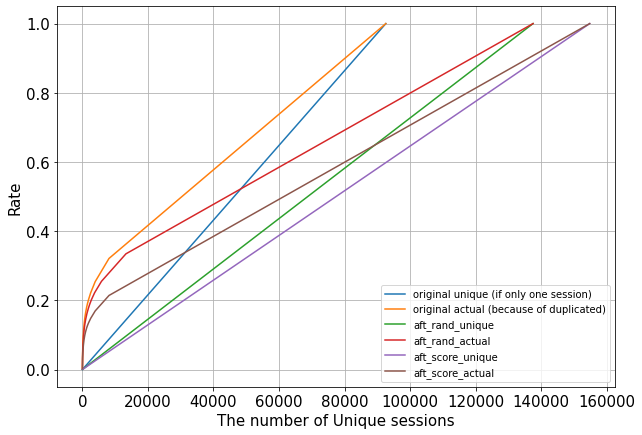

In [ ]:
original_unique, original_total, aft_rand_unique, aft_rand_total, aft_unique, aft_total = [], [], [], [], [], []

sum = 0
cnt = 0

original_unq_l = len(cntr)

for _ in cntr_sorted:
  sum += _[1]
  cnt += 1
  original_unique.append(cnt / original_unq_l)
  original_total.append(sum / nof_sessions)

# 원본 + 무작위 증강
sum = 0
cnt = 0
aft_rand_unq_l = len(aft_rand_augcntr)
nof_aft_rand_aug = len(tra_seqs_frac + rand_aug_sess)
for _ in aft_rand_augcntr_sorted:
  sum += _[1]
  cnt += 1
  aft_rand_unique.append(cnt / aft_rand_unq_l)
  aft_rand_total.append(sum / nof_aft_rand_aug)

# 원본 + 스코어 증강
sum = 0
cnt = 0
aft_unq_l = len(aft_augcntr)
nof_aft_aug = len(tra_seqs_frac + aug_sess)
for _ in aft_augcntr_sorted:
  sum += _[1]
  cnt += 1
  aft_unique.append(cnt / aft_unq_l)
  aft_total.append(sum / nof_aft_aug)


###########################

plt.figure(figsize=(10, 7))

plt.plot(original_unique)
plt.plot(original_total)
plt.plot(aft_rand_unique)
plt.plot(aft_rand_total)
plt.plot(aft_unique)
plt.plot(aft_total)


plt.legend(['original unique (if only one session)', 'original actual (because of duplicated)', 
            'aft_rand_unique', 'aft_rand_actual',
            'aft_score_unique', 'aft_score_actual'])
plt.xlabel('The number of Unique sessions', fontsize=15)
plt.ylabel('Rate', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)



In [ ]:
len(rand_aug_sess)

62236

In [ ]:
len(aug_sess)

62236

새로 생성된 세션들 중 중복 가장 많은 세션 : 110개 중복

In [ ]:
len(augcntr)

51550

새로 생성된 세션 고유 세션의 개수 : 51,532개

In [ ]:
a, b, c = '순위', '세션', '중복 수'

print(f'{a:>3}{b:>15}{c:>8}')
for i, _ in enumerate(cntr_sorted[:20]):
  print(f'{i:>3}{str(_[0]):>20}{_[1]:>9}')

 순위             세션    중복 수
  0             (5, 18)      386
  1            (18, 18)      383
  2          (115, 115)      331
  3              (9, 9)      321
  4              (5, 5)      276
  5            (94, 94)      272
  6            (55, 55)      201
  7          (176, 176)      176
  8             (18, 5)      158
  9            (25, 25)      145
 10           (27, 132)      144
 11          (126, 126)      135
 12          (363, 363)      132
 13          (106, 106)      128
 14            (12, 12)      126
 15            (29, 29)      123
 16          (112, 112)      115
 17          (779, 779)      111
 18              (4, 4)      109
 19            (17, 17)      103


In [ ]:
a, b, c = '순위', '세션', '중복 수'

print(f'{a:>3}{b:>15}{c:>8}')
for i, _ in enumerate(augcntr_sorted[:20]):
  print(f'{i:>3}{str(_[0]):>20}{_[1]:>9}')

 순위             세션    중복 수
  0             (5, 18)      110
  1             (18, 5)      106
  2              (5, 5)      104
  3            (18, 18)      102
  4         (18, 5, 18)       76
  5            (94, 10)       71
  6            (10, 94)       71
  7             (9, 10)       68
  8             (10, 9)       68
  9            (9, 115)       57
 10            (27, 27)       55
 11            (115, 9)       54
 12          (176, 442)       50
 13          (5, 5, 18)       49
 14            (10, 10)       48
 15          (132, 132)       47
 16            (26, 25)       46
 17          (10, 9, 9)       42
 18           (27, 132)       41
 19          (5, 18, 5)       41


In [ ]:
a, b, c = '순위', '세션', '중복 수'

print(f'{a:>3}{b:>15}{c:>8}')
for i, _ in enumerate(aft_aug_sorted[:20]):
  print(f'{i:>3}{str(_[0]):>20}{_[1]:>9}')

 순위             세션    중복 수
  0             (5, 18)      496
  1            (18, 18)      485
  2              (5, 5)      380
  3              (9, 9)      352
  4          (115, 115)      331
  5            (94, 94)      288
  6             (18, 5)      264
  7            (55, 55)      218
  8          (176, 176)      192
  9           (27, 132)      185
 10            (25, 25)      157
 11            (9, 115)      155
 12          (126, 126)      152
 13            (12, 12)      144
 14            (27, 27)      141
 15          (106, 106)      138
 16            (94, 10)      137
 17           (132, 27)      134
 18          (363, 363)      132
 19              (4, 4)      124


In [ ]:
for i, _ in enumerate(cntr_sorted[:20]):
  break

In [ ]:
_

((5, 18), 386)

In [ ]:
augcntr[_[0]]

110

In [ ]:
a, b, c, d = '순위', '세션', '중복 수',  '추가 수'

print(f'{a:>3}{b:>15}{c:>8}{d:>8}')
for i, _ in enumerate(cntr_sorted[:50]):
  print(f'{i:>3}{str(_[0]):>20}{_[1]:>9}{augcntr[_[0]]:>10}')

 순위             세션    중복 수    추가 수
  0             (5, 18)      386       119
  1            (18, 18)      383        91
  2          (115, 115)      331         0
  3              (9, 9)      321        33
  4              (5, 5)      276        95
  5            (94, 94)      272        17
  6            (55, 55)      201        15
  7          (176, 176)      176        13
  8             (18, 5)      158       114
  9            (25, 25)      145        13
 10           (27, 132)      144        42
 11          (126, 126)      135        14
 12          (363, 363)      132         0
 13          (106, 106)      128         5
 14            (12, 12)      126        21
 15            (29, 29)      123         0
 16          (112, 112)      115         0
 17          (779, 779)      111         0
 18              (4, 4)      109        17
 19            (17, 17)      103         5
 20          (111, 111)      100         6
 21            (9, 115)       98        59
 22           (132,

## 저장

In [ ]:
len(aug_sess)

37341

In [ ]:
aug_tra, aug_tra_l = crop_seqs(tra_seqs_frac + aug_sess)
aug_tra_final = (aug_tra, aug_tra_l)

filename_save = f'exps/experiment{experiment}/{y_or_d}/{y_or_d[0]}{int(1/frac):03}_score_aug.txt'
print(filename_save)

exps/experiment1/yoochoose/y064_score_aug.txt


In [ ]:
aug_tra, aug_tra_l = crop_seqs(tra_seqs_frac + rand_aug_sess)
aug_tra_final = (aug_tra, aug_tra_l)

filename_save = f'exps/experiment{experiment}/{y_or_d}/{y_or_d[0]}{int(1/frac):03}_rand_aug.txt'
print(filename_save)

exps/experiment1/yoochoose/y064_rand_aug.txt


In [ ]:
pickle.dump(aug_tra_final, open(filename_save, 'wb'))

# 모델 돌리기

In [ ]:
from models import narm, srgnn

## NARM

In [ ]:
trainfiles = [
              'y064_score_aug.txt',
              'y064_rand_aug.txt'
              ]


narm(trainfiles, 1, 'yoochoose', 1/64)

Namespace(batch_size=512, embed_dim=50, epoch=100, hidden_size=100, lr=0.001, lr_dc=0.1, lr_dc_step=80, test=False, test_file='exps/', topk=20, train_file='exps/', valid=False, valid_portion=0.1)
--------------------------------------------------
Dataset info:
Number of sessions: 699894
--------------------------------------------------
--------------------------------------------------
Dataset info:
Number of sessions: 55424
--------------------------------------------------
아이템 개수 : 17597
1 ~ 17597
모델에 들어가는 수 : 17598


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Epoch 0 : Recall@20: 42.7107, MRR@20: 19.6037 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 1 : Recall@20: 52.0445, MRR@20: 22.8629 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 2 : Recall@20: 57.3269, MRR@20: 24.6576 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 3 : Recall@20: 60.1276, MRR@20: 25.5770 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 4 : Recall@20: 62.2778, MRR@20: 26.4192 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 5 : Recall@20: 63.7167, MRR@20: 27.0988 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 6 : Recall@20: 64.4316, MRR@20: 27.3782 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 7 : Recall@20: 65.7164, MRR@20: 27.7704 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 8 : Recall@20: 66.8094, MRR@20: 28.2305 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 9 : Recall@20: 66.8220, MRR@20: 28.3188 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 10 : Recall@20: 67.3739, MRR@20: 28.5143 	y064_score_aug.txt 	 1/2 	 y064_test.txt
Epoch 11 : Recall@20: 67.9007, 

## SRGNN

In [ ]:
trainfiles = [
              'y064_thirdmethodar0.3cr0.3 - 복사본.txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (2).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (3).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (4).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (5).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (6).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (7).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (8).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (9).txt',
              'y064_thirdmethodar0.3cr0.3 - 복사본 (10).txt'
              ]

# 모델명(train_fns:학습 파일 리스트, experiment, y_or_d, frac)
srgnn(trainfiles, 1, 'yoochoose', 1/64)

# 시각화

file name                                          hits                 	 mrrs                

y064_train.txt                                     70.6404               	 30.0955             
y064_train2.txt                                    70.5006               	 30.1899             
y064_train3.txt                                    70.9217               	 30.2759             
y064_train4.txt                                    70.7425               	 30.1382             
y064_train5.txt                                    70.5884               	 30.2450             
y064_train6.txt                                    70.5992               	 30.1229             
y064_train7.txt                                    70.5634               	 30.2455             
y064_train8.txt                                    70.6135               	 30.1222             
y064_train9.txt                                    70.6727               	 30.3036             
y064_train10.txt                        

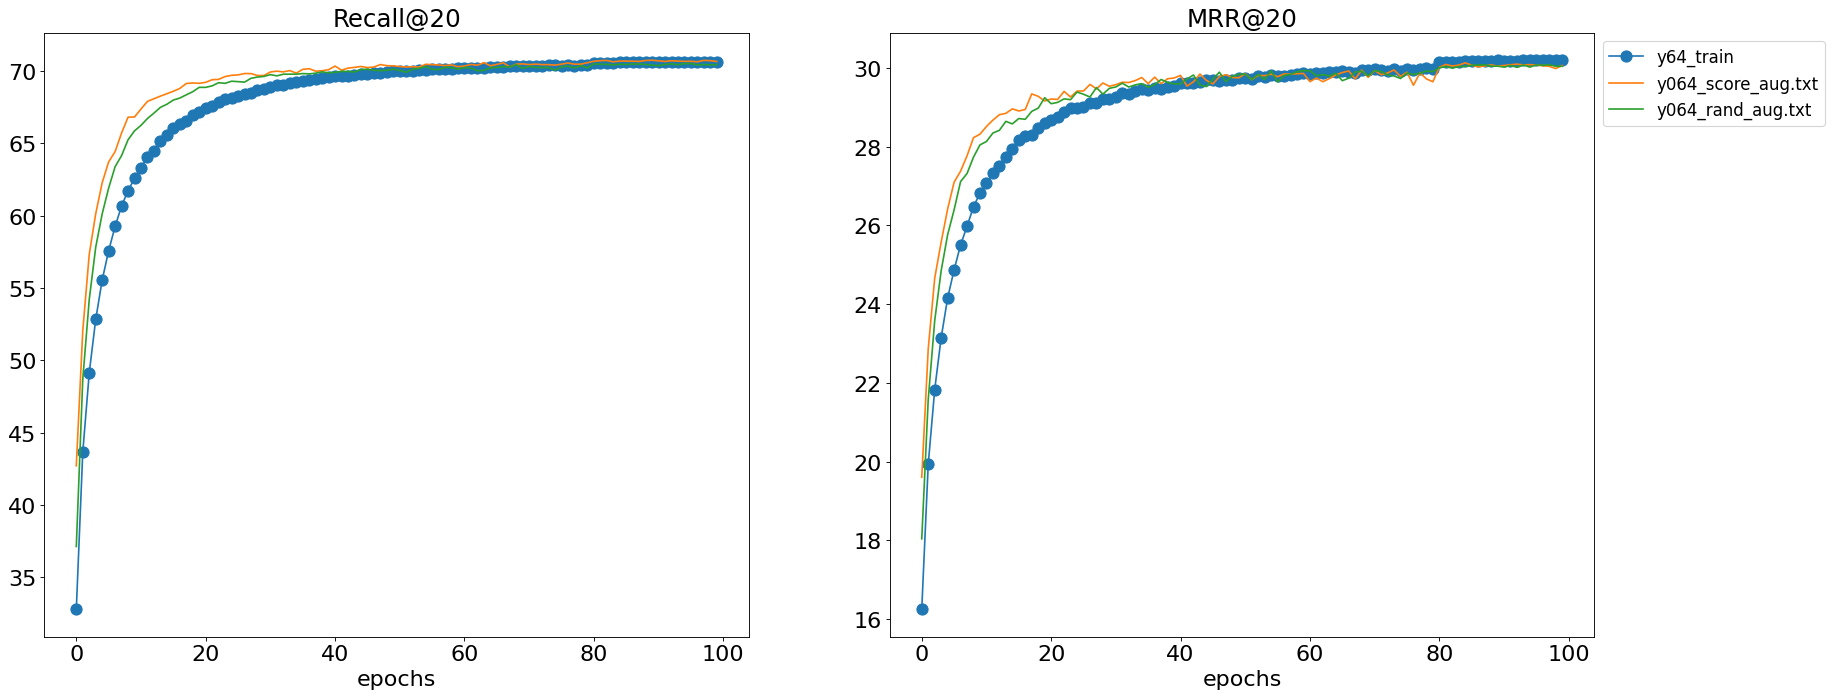

In [ ]:
experiment = 1
model='narm'  # 'narm' or 'srgnn'
y_or_d='yoochoose'  # 'yoochoose' or 'diginetica'
h_or_m='h'  # 'h' for hits / 'm' for mrrs

plot_result(model, experiment, y_or_d, 1/64)